In [1]:
import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import confusion_matrix

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device : {device}')

Using device : cuda


In [3]:
imgSize = 112

# Training transformer
transformer = transforms.Compose([
    transforms.RandomRotation(degrees = 20),
    
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),
    
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Validation transformer
valTransformer = transforms.Compose([
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
    

In [4]:
path = "C:/Users/Rhea Pandita/Desktop/College-AinDs/SEMESTER-6/IVP/Project/archive/train"
valPath = "C:\\Users\\Rhea Pandita\\Desktop\\College-AinDs\\SEMESTER-6\\IVP\\Project\\archive\\test"

trainData = datasets.ImageFolder(root = path, transform = transformer)
valData = datasets.ImageFolder(root = valPath, transform = valTransformer)

In [5]:
# Data loaders
batchSize = 64

trainLoader = DataLoader(trainData, batch_size = batchSize, shuffle = True, num_workers = 4)
valLoader = DataLoader(valData, batch_size = batchSize, shuffle = False, num_workers = 4)

In [6]:
# Using a pre-trained EfficientNetV2L model
model = models.efficientnet_v2_l(weights = 'DEFAULT')

# Modifying final classifier layer
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

In [7]:
model = nn.DataParallel(model).to(device)

In [8]:
# Defining the loss, optimizer, and annealer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = ReduceLROnPlateau(optimizer, threshold = 0.01, factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)

In [9]:
patience = 5
minDelta = 0.01
currentPatience = 0
bestLoss = float('inf')

In [10]:
# Gradient scaler for mixed-precision training
scaler = GradScaler()

# Lists to store training and validation metrics
trainLosses = []
valLosses = []
valAccs = []

# Training loop
epochs = 10

In [11]:
for epoch in range(epochs):
    # Training phase
    model.train()
    runningLoss = 0.0

    for inputs, labels in trainLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        runningLoss += loss.item()

    trainLoss = runningLoss / len(trainLoader)
    print(f'Epoch {epoch + 1}/{epochs} - Training Loss : {trainLoss:.2f}')
    trainLosses.append(trainLoss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        valLoss = 0.0
        correct = total = 0

        for inputs, labels in valLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valLoss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avgLoss = valLoss / len(valLoader)
        accuracy = correct / total * 100

        print(f'Validation Loss : {avgLoss:.2f} Validation Accuracy : {accuracy:.2f}%\n')
        valLosses.append(avgLoss)
        valAccs.append(accuracy)

        # Early stopping
        if avgLoss < bestLoss - minDelta:
            bestLoss = avgLoss
            currentPatience = 0
        else:
            currentPatience += 1
            if currentPatience >= patience:
                print('Early stopping triggered.')
                break

        scheduler.step(avgLoss)

Epoch 1/10 - Training Loss : 0.43
Validation Loss : 9.85 Validation Accuracy : 60.67%

Epoch 2/10 - Training Loss : 0.33
Validation Loss : 0.65 Validation Accuracy : 66.83%

Epoch 3/10 - Training Loss : 0.29
Validation Loss : 0.70 Validation Accuracy : 66.67%

Epoch 4/10 - Training Loss : 0.26
Validation Loss : 0.83 Validation Accuracy : 70.83%

Epoch 5/10 - Training Loss : 0.28
Validation Loss : 0.41 Validation Accuracy : 82.00%

Epoch 6/10 - Training Loss : 0.23
Validation Loss : 0.57 Validation Accuracy : 82.67%

Epoch 7/10 - Training Loss : 0.20
Validation Loss : 0.95 Validation Accuracy : 76.33%

Epoch 8/10 - Training Loss : 0.20
Validation Loss : 0.71 Validation Accuracy : 78.67%

Epoch 9/10 - Training Loss : 0.20
Validation Loss : 0.52 Validation Accuracy : 75.67%

Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 10/10 - Training Loss : 0.17
Validation Loss : 0.57 Validation Accuracy : 79.83%

Early stopping triggered.


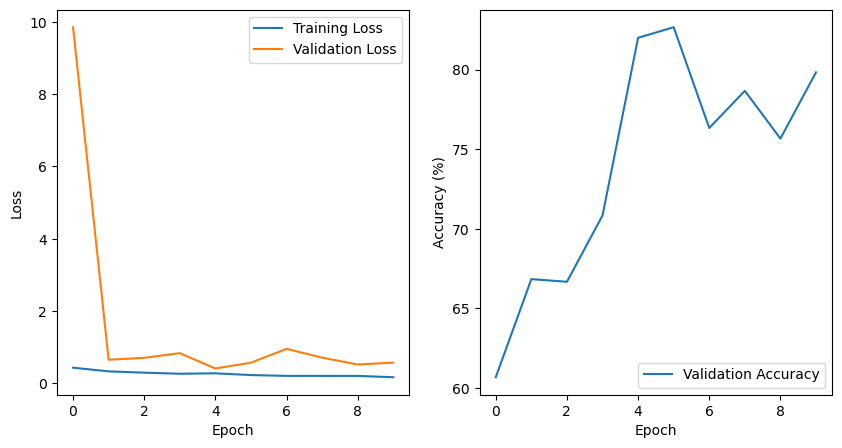

In [12]:
# Plotting training and validation metrics
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(trainLosses, label = 'Training Loss')
plt.plot(valLosses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valAccs, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

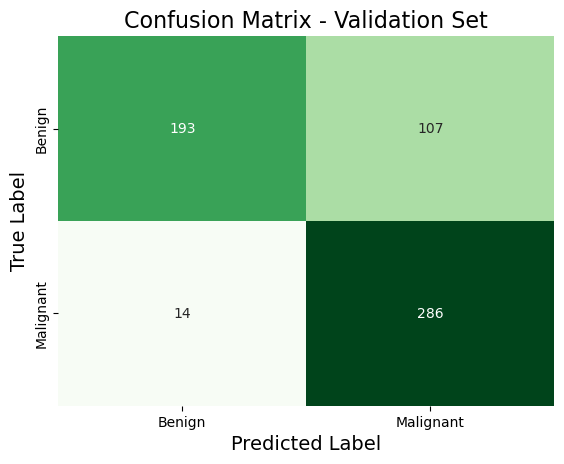

In [13]:
# Plotting confusion matrix for validation data
model.eval()
allLabels = []
allPreds = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs = model(inputs)
        predictions = (torch.sigmoid(outputs) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds.extend(predictions.cpu().numpy())

allLabels = np.array(allLabels)
allPreds = np.array(allPreds)

matrix = confusion_matrix(allLabels, allPreds)
sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = valData.classes, yticklabels = valData.classes, cbar = False)
plt.title('Confusion Matrix - Validation Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()